In [4]:
import hashlib
import os
import tarfile
import zipfile

import requests

#@save
DATA_HUB = dict()
DATA_URL = 'http://d2l-data.s3-accelerate.amazonaws.com/'

In [5]:
def download(name, cache_dir=os.path.join('..', 'data')):  #@save
    """Download a file inserted into DATA_HUB, return the local filename."""
    assert name in DATA_HUB, f"{name} does not exist in {DATA_HUB}."
    url, sha1_hash = DATA_HUB[name]
    os.makedirs(cache_dir, exist_ok=True)
    fname = os.path.join(cache_dir, url.split('/')[-1])
    if os.path.exists(fname):
        sha1 = hashlib.sha1()
        with open(fname, 'rb') as f:
            while True:
                data = f.read(1048576)
                if not data:
                    break
                sha1.update(data)
        if sha1.hexdigest() == sha1_hash:
            return fname  # Hit cache
    print(f'Downloading {fname} from {url}...')
    r = requests.get(url, stream=True, verify=True)
    with open(fname, 'wb') as f:
        f.write(r.content)
    return fname

In [6]:
def download_extract(name, folder=None):  #@save
    """Download and extract a zip/tar file."""
    fname = download(name)
    base_dir = os.path.dirname(fname)
    data_dir, ext = os.path.splitext(fname)
    if ext == '.zip':
        fp = zipfile.ZipFile(fname, 'r')
    elif ext in ('.tar', '.gz'):
        fp = tarfile.open(fname, 'r')
    else:
        assert False, 'Only zip/tar files can be extracted.'
    fp.extractall(base_dir)
    return os.path.join(base_dir, folder) if folder else data_dir

def download_all():  #@save
    """Download all files in the DATA_HUB."""
    for name in DATA_HUB:
        download(name)

In [7]:
DATA_HUB['kaggle_house_train'] = (  #@save
    DATA_URL + 'kaggle_house_pred_train.csv',
    '585e9cc93e70b39160e7921475f9bcd7d31219ce')

DATA_HUB['kaggle_house_test'] = (  #@save
    DATA_URL + 'kaggle_house_pred_test.csv',
    'fa19780a7b011d9b009e8bff8e99922a8ee2eb90')

In [21]:
import pandas as pd

train_data = pd.read_csv(download('kaggle_house_train'))
test_data = pd.read_csv(download('kaggle_house_test'))

In [22]:
train_labels = train_data.SalePrice
train_data.pop('SalePrice')
train_features = train_data
test_features = test_data

del train_data
del test_data

In [25]:
numeric_features = train_features.select_dtypes(exclude=['object']).columns
nulls = train_features[numeric_features].isna().sum()
nulls[nulls > 0]

LotFrontage    259
MasVnrArea       8
GarageYrBlt     81
dtype: int64

<AxesSubplot:ylabel='Density'>

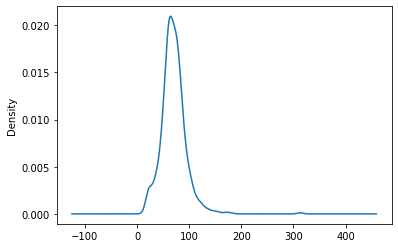

In [26]:
train_features.LotFrontage.plot.density()

<AxesSubplot:ylabel='Density'>

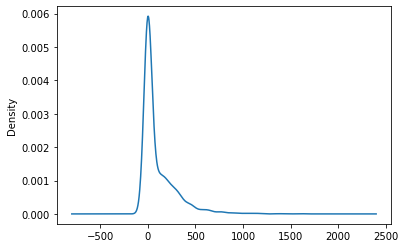

In [28]:
train_features.MasVnrArea.plot.density()

<AxesSubplot:ylabel='Density'>

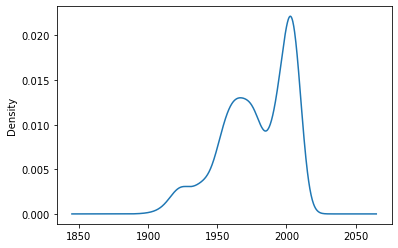

In [29]:
train_features.GarageYrBlt.plot.density()

In [32]:
train_features.fillna(train_features.mean(), inplace=True)
# note filling with train features mean only!
test_features.fillna(train_features.mean(), inplace=True)

C:\Users\roman\AppData\Local\Temp/ipykernel_15988/2511272739.py:1: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  train_features.fillna(train_features.mean(), inplace=True)
C:\Users\roman\AppData\Local\Temp/ipykernel_15988/2511272739.py:3: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  test_features.fillna(train_features.mean(), inplace=True)


In [34]:
train_features = pd.get_dummies(train_features, dummy_na=True)
test_features = pd.get_dummies(test_features, dummy_na=True)

In [49]:
from tensorflow.keras.initializers import GlorotUniform, RandomNormal, GlorotNormal, HeNormal, LecunNormal
from tensorflow.keras.layers.experimental.preprocessing import Normalization

from tensorflow import keras

from keras import callbacks
from tensorflow.keras.layers import Dense, ReLU
from keras import losses

In [105]:
def run_experiment(X_train, y_train, run_name,
                   activation=None,
                   kernel_initializer=None,
                   regularization='l2'):
    if activation is None:
        activation = ReLU()
    if kernel_initializer is None:
        kernel_initializer = GlorotUniform()

    normalizer = Normalization(axis=-1)
    normalizer.adapt(X_train)

    model = keras.Sequential([
        normalizer,
        Dense(512, kernel_regularizer=regularization, activation=activation, kernel_initializer=kernel_initializer),
        Dense(256, kernel_regularizer=regularization, activation=activation, kernel_initializer=kernel_initializer),
        Dense(128, kernel_regularizer=regularization, activation=activation, kernel_initializer=kernel_initializer),
        Dense(64, kernel_regularizer=regularization, activation=activation, kernel_initializer=kernel_initializer),
        Dense(1, activation='relu')
    ])

    model.compile(optimizer=keras.optimizers.Adam(learning_rate=.1),
                  loss=losses.MeanSquaredLogarithmicError())

    callback_list = [
        callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5,
                                    patience=3, min_lr=1e-6, mode='min'),
        callbacks.EarlyStopping(monitor='val_loss', patience=40,
                                min_delta=1e-6, mode='min',
                                restore_best_weights=True),
        callbacks.ModelCheckpoint(filepath=f'checkpoints/{run_name}',
                                  save_weights_only=True,
                                  monitor='val_loss', mode='min',),
        callbacks.TensorBoard(log_dir=f'logs/{run_name}'),
        callbacks.TerminateOnNaN()
    ]

    result = model.fit(x=X_train, y=y_train,
                       epochs=10000, validation_split=.1,
                       callbacks=callback_list,
                       verbose=0
                       )
    evaluation = model.evaluate(X_train, y_train, verbose=0, )
    print(f'{run_name:>30} | epochs: {len(result.epoch):4} | loss: {evaluation:>6.5}')
    return result

In [75]:
history = run_experiment(train_features, train_labels, run_name='baseline')

                      baseline | epochs:  178 | loss: 0.26968


In [76]:
for initializer in [RandomNormal(), GlorotNormal(), HeNormal(), LecunNormal()]:
    run_experiment(train_features, train_labels,
                   run_name=f'kernel_init_{initializer.__class__.__name__}',
                   kernel_initializer=initializer)

      kernel_init_RandomNormal | epochs:  192 | loss: 0.25442
      kernel_init_GlorotNormal | epochs:  147 | loss: 0.26995
          kernel_init_HeNormal | epochs:  169 | loss: 0.2597
       kernel_init_LecunNormal | epochs:  155 | loss: 0.28609


In [90]:
from keras.activations import sigmoid, tanh, relu, elu, selu, gelu

In [97]:
activation = sigmoid
run_experiment(train_features, train_labels,
               run_name=f'activation_{activation.__name__}',
               activation=activation,
               kernel_initializer=GlorotNormal())

            activation_sigmoid | epochs:  772 | loss: 0.2225


In [98]:
activation = tanh
run_experiment(train_features, train_labels,
               run_name=f'activation_{activation.__name__}',
               activation=activation,
               kernel_initializer=GlorotNormal())

               activation_tanh | epochs:  793 | loss: 0.16986


In [99]:
activation = relu
run_experiment(train_features, train_labels,
               run_name=f'activation_{activation.__name__}',
               activation=activation,
               kernel_initializer=HeNormal())

               activation_relu | epochs:  176 | loss: 0.28126


In [107]:
activation = elu
run_experiment(train_features, train_labels,
               run_name=f'activation_{activation.__name__}',
               activation=activation,
               kernel_initializer=HeNormal())

                activation_elu | epochs:  123 | loss: 0.35077


In [101]:
activation = selu
run_experiment(train_features, train_labels,
               run_name=f'activation_{activation.__name__}',
               activation=activation,
               kernel_initializer=HeNormal())

               activation_selu | epochs:  181 | loss: 0.28121


In [108]:
activation = gelu
run_experiment(train_features, train_labels,
               run_name=f'activation_{activation.__name__}',
               activation=activation,
               kernel_initializer=HeNormal())

               activation_gelu | epochs:  135 | loss: 0.29882
